In [1]:
import os

import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger


/tmp/ipykernel_14884/3894426074.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
# Reference : https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html

DATA_FOLDER = "./data"
BATCH_SIZE = 512
NUM_WORKERS = int(os.cpu_count() / 2)
print(NUM_WORKERS)

4


In [3]:
from utility import cifar10Utility, imageAugmentationUtility

# import importlib
# imageAugmentationUtility = importlib.reload(imageAugmentationUtility)

train_transforms, test_transforms = imageAugmentationUtility.get_cifar10_train_and_test_transforms(cifar10Utility.get_mean(),
                                                                                                   cifar10Utility.get_std())

train_dataset, validation_dataset, test_dataset  = cifar10Utility.get_datasets(train_transforms_collection=train_transforms,
                                                                   test_transforms_collection=test_transforms,
                                                                    data_folder=DATA_FOLDER)
print(f"Images in train_dataset are :{len(train_dataset)}, validation_dataset: {len(validation_dataset)}, and test_dataset: {len(test_dataset)}")
train_loader, validation_loader, test_loader = cifar10Utility.get_dataloaders(train_dataset=train_dataset,
                                                                    validation_dataset=validation_dataset,
                                                                    test_dataset=test_dataset,
                                                                    num_workers=NUM_WORKERS,
                                                                    batch_size=BATCH_SIZE)
print(f"Batches count in train data loader are :{len(train_loader)}, validation loader: {len(validation_loader)},and test data loader: {len(test_loader)}")


Files already downloaded and verified
Files already downloaded and verified
Images in train_dataset are :40000, validation_dataset: 10000, and test_dataset: 10000
Shape of test_dataloader batch_data [Batch, C, H, W]: torch.Size([512, 3, 32, 32])
Shape of test_dataloader label (label): torch.Size([512]) torch.int64
Batches count in train data loader are :79, validation loader: 20,and test data loader: 20


In [4]:
from utility import commonUtility
from utility import imageVisualizationUtility

Total number of batches: 79, batch_size : 512), selected batch_index: 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['car', 'plane', 'frog', 'horse', 'dog', 'deer', 'plane', 'dog']


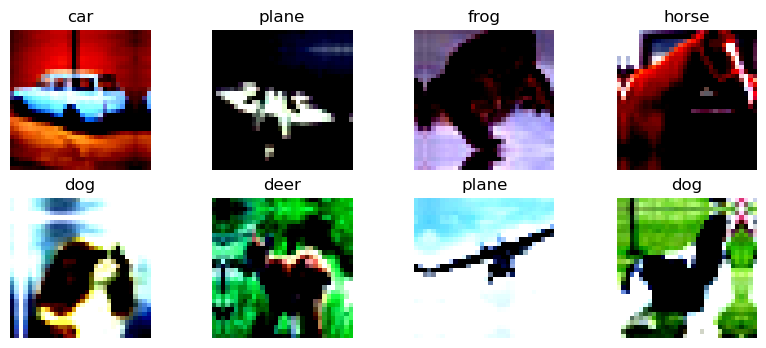

In [5]:
# get some random training images
images, labels = commonUtility.get_random_images_from_data_loader(train_loader, images_count=8)
labels = cifar10Utility.get_labels_names(labels_indexes=labels)
print(labels)
imageVisualizationUtility.show(images, labels)

# show images using torch vision grid function
# imageVisualizationUtility.show(torchvision.utils.make_grid(images), labels="-".join(labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


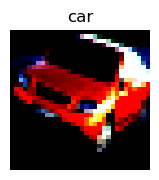

In [6]:
# Print single image from test dataset
import random
image, label = test_dataset[random.randint(0,len(test_dataset)-1)]
label = cifar10Utility.get_labels_names(labels_indexes=label)
imageVisualizationUtility.show(image, label)

In [7]:
from  models import modelHandler
import torchmetrics
import torchmetrics.classification
# modelHandler = importlib.reload(modelHandler)

model_handler = modelHandler.ModelHandler(batch_size=BATCH_SIZE)

In [8]:
# Creating lightning model instance. Internally it create resnet18 model
model = model_handler.get_lightning_model_instance()
model_handler.show_model_summary(model)

   | Name          | Type               | Params
------------------------------------------------------
0  | model         | ResNet             | 11.2 M
1  | model.conv1   | Conv2d             | 1.7 K 
2  | model.bn1     | BatchNorm2d        | 128   
3  | model.relu    | ReLU               | 0     
4  | model.maxpool | Identity           | 0     
5  | model.layer1  | Sequential         | 147 K 
6  | model.layer2  | Sequential         | 525 K 
7  | model.layer3  | Sequential         | 2.1 M 
8  | model.layer4  | Sequential         | 8.4 M 
9  | model.avgpool | AdaptiveAvgPool2d  | 0     
10 | model.fc      | Linear             | 5.1 K 
11 | train_acc     | MulticlassAccuracy | 0     
12 | test_acc      | MulticlassAccuracy | 0     
13 | valid_acc     | MulticlassAccuracy | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


lr: 0.002


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Restoring states from the checkpoint path at /home/ec2-user/my/repo/github/erav2-session13/.lr_find_e6bff098-5fec-4350-a499-1dae40101d2e.ckpt
Restored all states from the checkpoint file at /home/ec2-user/my/repo/github/erav2-session13/.lr_find_e6bff098-5fec-4350-a499-1dae40101d2e.ckpt


Suggested LR: 0.000478630092322638


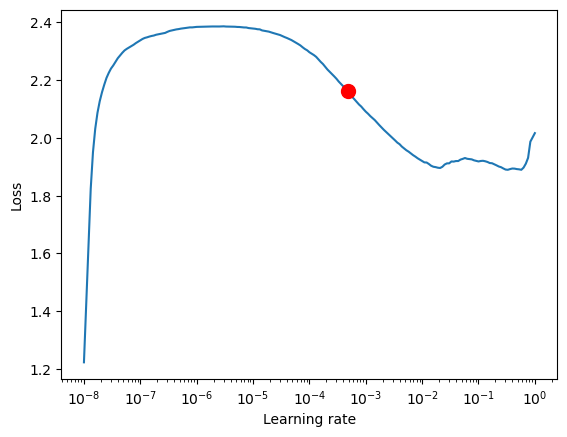

In [9]:
from lightning.pytorch.loggers import TensorBoardLogger
MAX_EPOCHS = 35

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"), #[TensorBoardLogger(save_dir="logs/"), CSVLogger(save_dir="logs/")],
    auto_lr_find=True,
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)]
)

# Find the learning rate
# result = trainer.tune(model, train_loader)
lr_finder = trainer.tuner.lr_find(model, train_loader, validation_loader, num_training=200)
new_lr = lr_finder.suggestion()
print(f"Suggested LR: {new_lr}")
fig = lr_finder.plot(suggest=True)
fig.show()

In [10]:
# Setting new learning rate
model.hparams.lr = new_lr
trainer.fit(model, train_loader, validation_loader)
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | test_acc  | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


lr: 0.000478630092322638


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7961000204086304     │
│         test_loss         │    0.6004763245582581     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6004763245582581, 'test_acc': 0.7961000204086304}]

logs/lightning_logs/version_3/metrics.csv


,lr-Adam,train_loss_step,train_acc_step,valid_acc,train_loss_epoch,train_acc_epoch,test_loss,test_acc
epoch,,,,,,,,
NaN,0.004826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.748022,0.351562,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,0.3054,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,1.893708,0.309325,NaN,NaN
NaN,0.007343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
33.0,NaN,0.637579,0.775391,NaN,NaN,NaN,NaN,NaN
33.0,NaN,NaN,NaN,0.7661,NaN,NaN,NaN,NaN
33.0,NaN,NaN,NaN,NaN,0.632402,0.778450,NaN,NaN


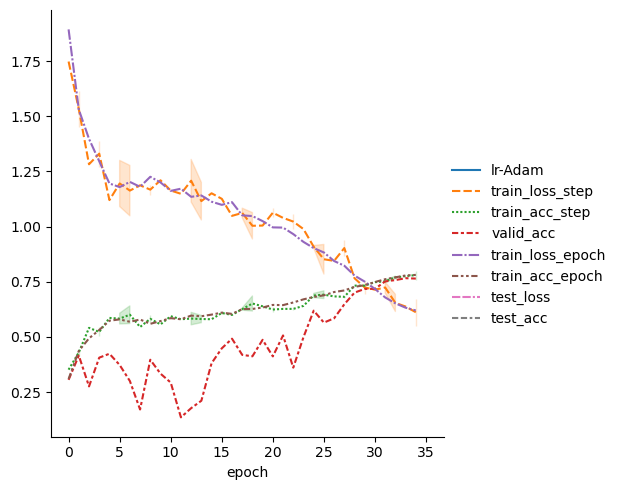

In [11]:
print(f"{trainer.logger.log_dir}/metrics.csv")
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

del metrics["step"]
del metrics["valid_loss"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head(-5)) # Last five rows
sn.relplot(data=metrics, kind="line")

In [12]:
MODEL_NAME = "lightning_resnet18.pth"

In [13]:
# Saving model 
torch.save(model.state_dict(), f"{trainer.logger.log_dir}/{MODEL_NAME}")
# Saving at top level as well
torch.save(model.state_dict(), MODEL_NAME)

In [14]:
# Creating new model instance and loading weights from model file
# model_location = f"{trainer.logger.log_dir}/lightning_resnet18.pth"

new_loaded_model = model_handler.get_lightning_model_instance(saved_model=MODEL_NAME)
model_handler.show_model_summary(new_loaded_model)

# Set the model to evaluation mode (disable dropout, randomness, etc.)
new_loaded_model = new_loaded_model.eval()

In [15]:

batch_images, batch_labels = commonUtility.get_random_images_batch_and_labels_from_data_loader(test_loader)

#  {"images" : images, "predicted_labels" : predicted_labels, "actual_labels" : actual_labels}
non_matched_results, matched_results = commonUtility.get_images_for_matched_and_non_matched_model_predictions(new_loaded_model, batch_images, batch_labels, max_image_count=10)

Total number of batches: 20, batch_size : 512), selected batch_index: 7
matched_indices: 416
non_matched_indices: 96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

For Matched results


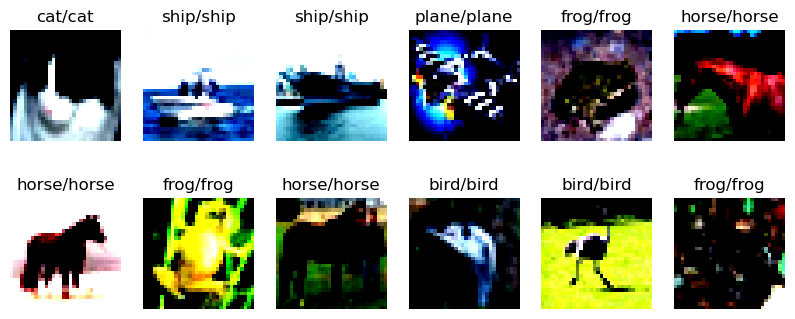

In [16]:
print("For Matched results")
predicted_labels_names = cifar10Utility.get_labels_names(labels_indexes=matched_results["predicted_labels"])
actual_labels_names = cifar10Utility.get_labels_names(labels_indexes=matched_results["actual_labels"])
matched_combined_labels = commonUtility.combine_labels(predicted_labels_names, actual_labels_names)
imageVisualizationUtility.show(matched_results["images"], matched_combined_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

For Non-Matched results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


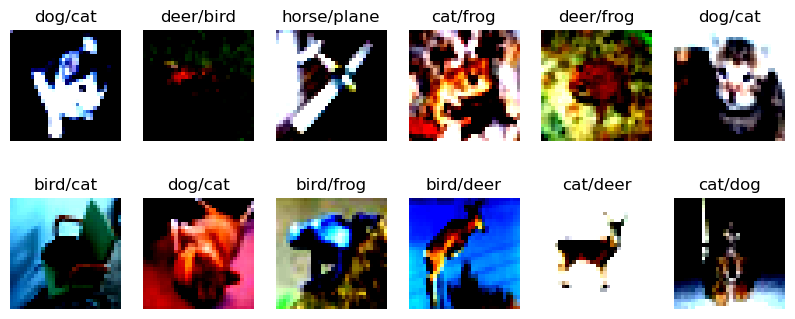

In [17]:
print("For Non-Matched results")
predicted_labels_names = cifar10Utility.get_labels_names(labels_indexes=non_matched_results["predicted_labels"])
actual_labels_names = cifar10Utility.get_labels_names(labels_indexes=non_matched_results["actual_labels"])
non_matched_combined_labels = commonUtility.combine_labels(predicted_labels_names, actual_labels_names)
imageVisualizationUtility.show(non_matched_results["images"], non_matched_combined_labels)

In [18]:
from utility import gradcamUtility

For Matched results


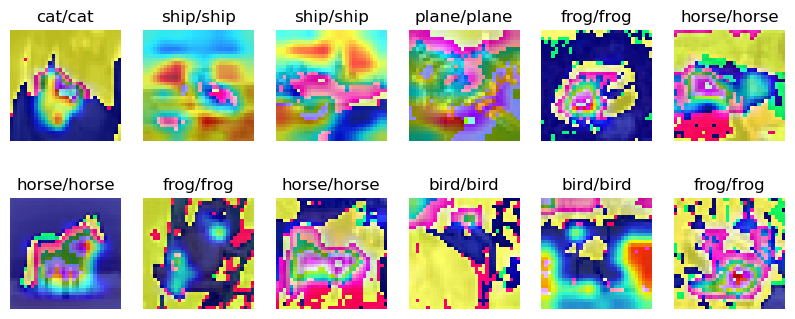

In [19]:
print("For Matched results")
# param image_weight: The final result is image_weight * img + (1-image_weight) * mask
heatmap_overlaid_images = gradcamUtility.create_grad_cam_overlaid_images(new_loaded_model.model, 
                                                                         [new_loaded_model.model.layer3[-1]],
                                                                         images=matched_results["images"],
                                                                         predictions_labels=matched_results["predicted_labels"],
                                                                         actual_labels=matched_results["actual_labels"],
                                                                         image_weight=0.98
                                                                         )
imageVisualizationUtility.show(heatmap_overlaid_images, matched_combined_labels)

For Non-Matched results


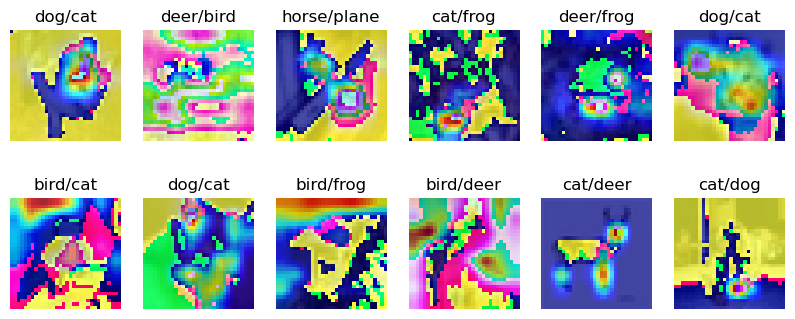

In [20]:
print("For Non-Matched results")
# param image_weight: The final result is image_weight * img + (1-image_weight) * mask
heatmap_overlaid_images = gradcamUtility.create_grad_cam_overlaid_images(new_loaded_model.model, 
                                                                         [new_loaded_model.model.layer3[-1]],
                                                                         images=non_matched_results["images"],
                                                                         predictions_labels=non_matched_results["predicted_labels"],
                                                                         actual_labels=non_matched_results["actual_labels"],
                                                                         image_weight = 0.98
                                                                         )
imageVisualizationUtility.show(heatmap_overlaid_images, non_matched_combined_labels)